## Модули

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import plotly.express as px

from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self, X, y=None):
        return self # not relevant here

    def transform(self, X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

## Постановка задачи

Мы предскажем стоимость подержанного авто по его описанию. Но теперь подойдём к задаче, вооружившись более сильным методом - градиентным бустингом. Снова предположим, что вы работаете в компании, которая занимается размещением объявлений. Но в этот раз вы собрали выборку объявлений, размещённых в США, и должны предсказать цену в долларах. 

В качестве метрики качества у нас будет $RMSE$, и нам необходимо побороть baseline с $RMSE = 8500$

## Загрузка данных 

In [3]:
df = pd.read_csv('car_price_train.csv')

In [4]:
df.head()

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,target
0,portland,2012.0,ford,f-150,NaN,6 cylinders,gas,108410.0,clean,automatic,rwd,NaN,truck,white,or,17995
1,boise,2011.0,lexus,rx350 awd,like new,6 cylinders,gas,146234.0,clean,automatic,4wd,NaN,SUV,white,id,14995
2,milwaukee,2012.0,volkswagen,jetta,good,4 cylinders,diesel,110000.0,clean,manual,fwd,compact,wagon,black,wi,5000
3,fresno,2002.0,ford,f-550 super duty,good,10 cylinders,gas,147848.0,rebuilt,automatic,rwd,full-size,truck,white,ca,16500
4,spokane,2017.0,ram,1500,NaN,NaN,gas,80732.0,clean,automatic,4wd,NaN,pickup,blue,id,30999


In [5]:
df.describe()

,year,odometer,target
count,54642.000000,5.456600e+04,5.488800e+04
mean,2010.782292,1.010761e+05,1.643329e+05
std,9.338066,2.059621e+05,2.106862e+07
min,1910.000000,0.000000e+00,1.010000e+02
25%,2008.000000,4.437500e+04,7.000000e+03
50%,2013.000000,9.134250e+04,1.399900e+04
75%,2016.000000,1.359540e+05,2.569825e+04
max,2022.000000,1.000000e+07,3.736929e+09


## Предобработка данных

In [6]:
df[df.target > 1e6]

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,target
3050,nashville,2021.0,NaN,Rare Car,good,8 cylinders,gas,0.0,clean,other,rwd,NaN,NaN,NaN,tn,123456789
5676,new,1994.0,chevrolet,corvette,NaN,8 cylinders,gas,1111111.0,clean,manual,NaN,NaN,NaN,NaN,nh,1111111
6944,spokane,2007.0,ram,2500,good,8 cylinders,diesel,170000.0,rebuilt,automatic,4wd,full-size,pickup,black,id,17000000
16424,modesto,2020.0,jeep,NaN,NaN,NaN,gas,1000.0,clean,automatic,4wd,NaN,NaN,NaN,ca,1111111111
17087,orlando,2014.0,dodge,journey,NaN,4 cylinders,gas,135888.0,clean,automatic,fwd,NaN,SUV,NaN,fl,6995495
42844,eugene,2007.0,toyota,tundra,excellent,8 cylinders,gas,164000.0,clean,automatic,4wd,full-size,pickup,silver,or,3736928711
49622,south,2000.0,mercedes-benz,benz s430,NaN,NaN,gas,100000.0,clean,automatic,NaN,NaN,NaN,NaN,nj,3024942282
49956,minneapolis,1999.0,chevrolet,corvette,NaN,NaN,gas,200000.0,clean,automatic,NaN,NaN,NaN,NaN,mn,1111111


In [7]:
filler = df.target.quantile(.99)
df.target = df.target.apply(lambda price: filler if price > filler else price)

In [8]:
most_popular = {}
for col in df.columns.drop('target', 1):
    most_popular[col] = df[col].dropna().value_counts().index[0]

In [9]:
most_popular

{'region': 'columbus',
 'year': 2017.0,
 'manufacturer': 'ford',
 'model': 'f-150',
 'condition': 'excellent',
 'cylinders': '6 cylinders',
 'fuel': 'gas',
 'odometer': 1.0,
 'title_status': 'clean',
 'transmission': 'automatic',
 'drive': '4wd',
 'size': 'full-size',
 'type': 'sedan',
 'paint_color': 'white',
 'state': 'ca'}

In [10]:
most_popular['odometer'] = 100000
most_popular['drive'] = 'fwd'
most_popular['year'] = 2013

In [11]:
most_popular

{'region': 'columbus',
 'year': 2013,
 'manufacturer': 'ford',
 'model': 'f-150',
 'condition': 'excellent',
 'cylinders': '6 cylinders',
 'fuel': 'gas',
 'odometer': 100000,
 'title_status': 'clean',
 'transmission': 'automatic',
 'drive': 'fwd',
 'size': 'full-size',
 'type': 'sedan',
 'paint_color': 'white',
 'state': 'ca'}

In [12]:
for col in df.columns.drop('target', 1):
    df[col] = df[col].fillna(most_popular[col])

## Выделение train-test выборок

In [13]:
X = df.drop('target', 1)
y = df.target

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42
)

C:\Users\HardWorkingStation\AppData\Local\Temp\ipykernel_1524\2944837455.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = df.drop('target', 1)


In [14]:
LE = MultiColumnLabelEncoder(['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel',
                              'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color',
                              'state'])

In [15]:
X_train = LE.fit_transform(X_train_raw)

 ## Написание бустинга

Ниже написан набросок бустинга (не обязательно для деревьев решений) 

Необходимо разобраться в коде и логике описанной и исправить все ошибки, заставить код работать.

Ниже представлен код, необходимо прогнать ваш бустинг через этот код и получить схожие результаты

P.S. Для особенно любопытствующих рекомендую попробовать реализовать схему OrderedBoosting которую мы обсуждали.

С любыми вопросами тегайте в teamwork буду рад ответить

In [34]:
# class MyBoosting:
#     def __init__(self, base_clf, n_clfs: int = 5, lr: float = 0.01, **kwargs):
#         self.base_clf = base_clf
#         self.n_clfs = n_clfs
#         self.lr = lr
#         self.clf_collection = []
#         self.kwargs = kwargs
#
#     def fit(self, X, y):
#         y_hat = y.copy()
#
#         for i in range(self.n_clfs):
#             model = self.base_clf(**self.kwargs).fit(X, y_hat)
#             y_hat = y - model.predict(X) * self.lr
#             self.clf_collection.append(model)
#
#
#     def predict(self, X):
#         y_pred_collection = []
#
#         for model in self.clf_collection:
#             pred = model.predict(X) * self.lr
#             y_pred_collection.append(pred)
#
#         return sum(y_pred_collection)

class MyBoosting:

    try:
        from sklearn.metrics import mean_squared_error
    except:
        raise 'Sklearn must be installed before. Try: pip install sklearn'

    def __init__(
            self,
            base_clf,
            n_estimators: int = 1,
            max_depth: int = 1,
            learning_rate: float = 0.01,
            **kwargs
    ):

        self.fitted_models: list = []
        self.base_clf = base_clf
        self.n_estimators = n_estimators
        self.lr = learning_rate
        self.boosted_predictions: list
        self.max_depth = max_depth
        self.losses = []

    def __get_zero_y_pred(self, y=None, shape=None):
        if shape is None:
            return np.zeros(y.shape)
        else:
            return np.zeros(shape)

    def fit(self, X, y):
        self.y = y.copy()
        # начальные значения для финального результата (y_hat_final)
        # и предикта каждой модели (y_pred для первой итерации цикла)
        y_hat_final = self.__get_zero_y_pred(y)
        for _ in tqdm(range(0, self.n_estimators)):
            try:
                self.model = self.base_clf(max_depth=self.max_depth, n_jobs=-1).fit(X, y)
            except:
                self.model = self.base_clf().fit(X, y)

            y_pred = self.model.predict(X)
            y = y - y_pred * self.lr
            y_hat_final += self.lr * y_pred
            self.fitted_models.append(self.model)
            self.losses.append(np.sqrt(mse(self.y, y_hat_final)))
        self.boosted_predictions = y_hat_final


    def fit_ordered(self, X: pd.DataFrame, y: pd.DataFrame, n_iter=10):
        # создаем список с перестановками равный количеству сэмплов - 1,
        # для того чтобы не обучать дерево на одном сэмпле
        # в первой итерации (ибо это не имеет смысла), а обучить на двух сэмплах
        self.y = y.copy().reset_index(drop=True)
        self.X = X.copy().reset_index(drop=True)
        permutations = [np.random.permutation(y) for _ in range(self.y.shape[0])]
        y_hat = self.__get_zero_y_pred(self.y)
        y_hat_ordered = []
        for _ in tqdm(range(n_iter)):
            for i in range(self.y.shape[0]):
                y_hat_ordered.append(self.y[i] - permutations[i - 1][i])
            # начинаем с 2 т.к. если начнем с 1, то i-1=0, обучаться на единственном первом семпле бессмысленно
            for i in range(2, self.y.shape[0]):
                self.model = self.base_clf(max_depth=self.max_depth).fit(self.X.to_numpy()[:i-1], y_hat_ordered[:i-1])
                self.fitted_models.append(self.model)
                y_hat[i] = y_hat[i] + self.model.predict(self.X.to_numpy()[i].reshape(1, -1)) * self.lr
            self.losses.append(np.sqrt(mse(self.y, y_hat)))
        self.best_estimator = self.model


    def predict(self, X):
        # возвращаем сумму предиктов ансамбля
        return np.sum([self.lr * model.predict(X) for model in self.fitted_models], axis=0)

    def fit_predict(self, X, y):
        self.fit(X, y)
        return self.predict(X)

Ну и ключевое задание остается неизменным необходимо добиться лучшего возможного качества на отложенной выборке

## Обучение бустинга

C:\Users\HardWorkingStation\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target', ylabel='Density'>

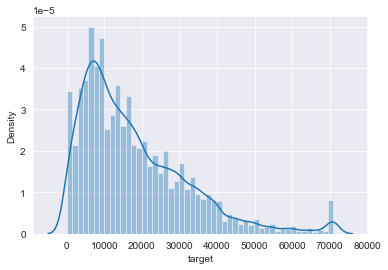

In [17]:
sns.distplot(y_train)

In [32]:
cbr = MyBoosting(DecisionTreeRegressor, max_depth=3, n_estimators=10, learning_rate=0.99)
cbr.fit_ordered(X_train.iloc[:1000,:], y_train.iloc[:1000], n_iter=20)
print('RMSE', mse(y_test, cbr.best_estimator.predict(LE.transform(X_test_raw))) ** .5)

  0%|          | 0/20 [00:00<?, ?it/s]

RMSE 22009.373409899552


C:\Users\HardWorkingStation\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names



In [35]:
fig = px.scatter(cbr.losses, title='Кривая обучения, рассчитанная по RMSE')

fig.update_layout(
    showlegend = False
)

fig.update_xaxes(
    title = 'Итерация'
)

fig.update_yaxes(
    title = 'RMSE'
)

fig.show()

In [19]:
cbr = MyBoosting(DecisionTreeRegressor, max_depth=3, n_estimators=10, learning_rate=0.99)
cbr.fit(X_train, y_train)

#cbr_2 = MyBoosting(DecisionTreeRegressor, max_depth=1, n_estimators=10, learning_rate=0.1)
#cbr_2.fit(X_train, y_train)

print('RMSE', mse(y_test, cbr.predict(LE.transform(X_test_raw))) ** .5)

  0%|          | 0/10 [00:00<?, ?it/s]

ValueError: Number of labels=16327 does not match number of samples=100

In [40]:
cbr.fitted_models[0].predict(LE.transform(X_test_raw))[:5]

array([26500., 11995., 11111., 11488.,  7499.])

In [36]:
cbr.fitted_models[3].predict(LE.transform(X_test_raw))[:5]

array([0.0265  , 0.0113  , 0.011111, 0.011488, 0.006999])

In [38]:
cbr.predict(LE.transform(X_test_raw))[:5]

array([26499.99998077, 11988.1187624 , 11110.99998218, 11488.05013754,
        7493.99999353])

In [20]:
cbr_2.fitted_models[1].predict(LE.transform(X_test_raw))

array([23850. ,  4950. ,  9999.9, ..., 32391. , 25199.1, 19786.5])

In [220]:
fig = px.scatter(cbr.losses, title='Кривая обучения, рассчитанная по RMSE')

fig.update_layout(
    showlegend = False
)

fig.update_xaxes(
    title = 'Итерация'
)

fig.update_yaxes(
    title = 'RMSE'
)

fig.show()

## Построим простейшую кривую обучения

In [49]:
boost_dict = {}

learning_curve_005 = []
for i in [100, 200, 400, 600, 1600]:
    boost_dict[f'boost_{i}'] = MyBoosting(DecisionTreeRegressor, max_depth=5, n_estimators=i, learning_rate=0.05)
    boost_dict[f'boost_{i}'].fit(X_train, y_train)
    learning_curve_005.append(mse(y_test, boost_dict[f'boost_{i}'].predict(LE.transform(X_test_raw))) ** .5)

learning_curve_01 = []
for i in [100, 200, 400, 800, 1600]:
    boost_dict[f'boost_{i}'] = MyBoosting(DecisionTreeRegressor, max_depth=5, n_estimators=i, learning_rate=0.1)
    boost_dict[f'boost_{i}'].fit(X_train, y_train)
    learning_curve_01.append(mse(y_test, boost_dict[f'boost_{i}'].predict(LE.transform(X_test_raw))) ** .5)

learning_curve_05 = []
for i in [100, 200, 400, 800, 1600]:
    boost_dict[f'boost_{i}'] = MyBoosting(DecisionTreeRegressor, max_depth=5, n_estimators=i, learning_rate=0.5)
    boost_dict[f'boost_{i}'].fit(X_train, y_train)
    learning_curve_05.append(mse(y_test, boost_dict[f'boost_{i}'].predict(LE.transform(X_test_raw))) ** .5)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/400 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/1600 [00:00<?, ?it/s]

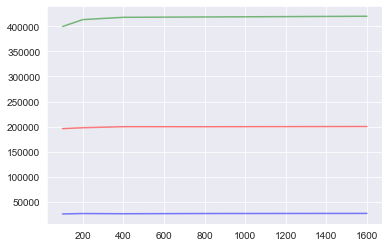

In [50]:
plt.plot([100, 200, 400, 600, 1600], learning_curve_005, 'g', alpha=.5)
plt.plot([100, 200, 400, 800, 1600], learning_curve_01, 'r', alpha=.5)
plt.plot([100, 200, 400, 800, 1600], learning_curve_05, 'b', alpha=.5)

In [61]:
cbr = MyBoosting(CatBoostRegressor, max_depth=5, n_estimators=10, learning_rate=0.1)
cbr.fit(X_train, y_train)
print('RMSE: ', mse(y_test, cbr.predict(LE.transform(X_test_raw))) ** .5)

  0%|          | 0/10 [00:00<?, ?it/s]

Learning rate set to 0.074423
0:	learn: 13747.3203105	total: 17.9ms	remaining: 17.9s
1:	learn: 13288.8923937	total: 21.3ms	remaining: 10.7s
2:	learn: 12877.9498323	total: 24.8ms	remaining: 8.24s
3:	learn: 12502.4181192	total: 27.9ms	remaining: 6.96s
4:	learn: 12161.5060633	total: 31.3ms	remaining: 6.23s
5:	learn: 11856.8196316	total: 34.6ms	remaining: 5.73s
6:	learn: 11584.4796919	total: 37.8ms	remaining: 5.37s
7:	learn: 11327.1759819	total: 41ms	remaining: 5.08s
8:	learn: 11111.0096177	total: 44.1ms	remaining: 4.86s
9:	learn: 10912.7851584	total: 47.6ms	remaining: 4.71s
10:	learn: 10724.7646552	total: 50.8ms	remaining: 4.56s
11:	learn: 10556.5627214	total: 54ms	remaining: 4.45s
12:	learn: 10416.3272692	total: 57.1ms	remaining: 4.33s
13:	learn: 10280.5229068	total: 60.4ms	remaining: 4.25s
14:	learn: 10159.1392113	total: 63.4ms	remaining: 4.16s
15:	learn: 10055.1006911	total: 66.5ms	remaining: 4.09s
16:	learn: 9960.1012627	total: 69.5ms	remaining: 4.02s
17:	learn: 9873.4013421	total: 72

In [60]:
cbr = MyBoosting(DecisionTreeRegressor, max_depth=5, n_estimators=10, learning_rate=0.1)
cbr.fit(X_train, y_train)
print('RMSE: ', mse(y_test, cbr.predict(LE.transform(X_test_raw))) ** .5)

  0%|          | 0/10 [00:00<?, ?it/s]

RMSE:  114316.27846474876


In [32]:
cbr = MyBoosting(CatBoostRegressor, max_depth=5, n_estimators=400, learning_rate=0.1)
cbr.fit(LE.transform(X), y)

0:	learn: 13633.1215286	total: 3.98ms	remaining: 1.59s
1:	learn: 13039.3184994	total: 7.88ms	remaining: 1.57s
2:	learn: 12518.9013464	total: 11.4ms	remaining: 1.5s
3:	learn: 12063.7301473	total: 14.7ms	remaining: 1.46s
4:	learn: 11672.5990815	total: 18.3ms	remaining: 1.45s
5:	learn: 11335.6147194	total: 21.8ms	remaining: 1.43s
6:	learn: 11031.1405156	total: 25.2ms	remaining: 1.42s
7:	learn: 10784.3422097	total: 28.6ms	remaining: 1.4s
8:	learn: 10550.3979139	total: 31.8ms	remaining: 1.38s
9:	learn: 10346.1252153	total: 35.3ms	remaining: 1.38s
10:	learn: 10183.0269336	total: 38.8ms	remaining: 1.37s
11:	learn: 10042.6379433	total: 42.1ms	remaining: 1.36s
12:	learn: 9919.7428534	total: 45.4ms	remaining: 1.35s
13:	learn: 9817.3365297	total: 48.4ms	remaining: 1.33s
14:	learn: 9710.3908098	total: 51.9ms	remaining: 1.33s
15:	learn: 9622.5085169	total: 55.3ms	remaining: 1.33s
16:	learn: 9536.0973982	total: 58.6ms	remaining: 1.32s
17:	learn: 9463.9631780	total: 62ms	remaining: 1.32s
18:	learn: 9

In [33]:
test = pd.read_csv('car_price_test.csv')
for col in df.columns.drop(['target'], 1):
    test[col] = test[col].fillna(most_popular[col])

test = LE.transform(test)
result = test[['id']]
result['price'] = cbr.predict(test.drop('id', 1))

C:\Users\HardWorkingStation\AppData\Local\Temp\ipykernel_27076\3747781232.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  result['price'] = cbr.predict(test.drop('id', 1))
C:\Users\HardWorkingStation\AppData\Local\Temp\ipykernel_27076\3747781232.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['price'] = cbr.predict(test.drop('id', 1))


In [34]:
result

,id,price
0,0,1489.019481
1,1,886.221337
2,2,143.570195
3,3,82.627400
4,4,607.759105
...,...,...
27026,27030,159.548601
27027,27031,602.400033
27028,27032,475.043198
27029,27033,1418.394294
